In [32]:
import numpy as np
from find_neighbours import find_neighbours, _genpath
from dggrid4py import DGGRIDv7
import tempfile
import shapely
import geopandas as gpd
from matplotlib import pyplot as plt
import math

In [3]:
tmp = tempfile.TemporaryDirectory()
dggrid = DGGRIDv7('/home/dick/micromamba/envs/xdggs/bin/dggrid', working_dir=tmp.name, silent=True)

In [4]:
# to confirm the rotation is changing 19 from odd to even , -19 from even to odd 
#box = shapely.geometry.box(2542500., 1561500. ,6013500., 5417500)
#box = gpd.GeoSeries([box], crs='EPSG:3035').to_crs('wgs84')
#reg5 = dggrid.grid_cell_polygons_for_extent('IGEO7', 9, clip_geom=box.geometry.values[0], output_address_type='Z7_STRING')
#reg5['name']
#cellId = reg5['name'][0]
#reg6 = dggrid.grid_cell_polygons_from_cellids([cellId], 'IGEO7', 2, clip_subset_type='COARSE_CELLS', clip_cell_res=1, input_address_type='Z7_STRING', output_address_type='Z7_STRING')
#reg7 = dggrid.grid_cell_polygons_from_cellids([cellId], 'IGEO7', 3, clip_subset_type='COARSE_CELLS', clip_cell_res=1, input_address_type='Z7_STRING', output_address_type='Z7_STRING')
#from matplotlib import pyplot as plt
#fig, ax = plt.subplots(1,1,)
#reg7.plot(ax=ax,facecolor='none', edgecolor='red')
#reg6.plot(ax =ax, facecolor='none',edgecolor='blue')
#reg5[reg5['name'] == cellId].plot(ax=ax,facecolor='none')

In [5]:
directions = np.array([
           complex(0,0), # 0 
           complex(0.5,np.sqrt(3)/2), #1 
           complex(0.5,-np.sqrt(3)/2), #2
           complex(1,0), #3
           complex(-1,0), #4
           complex(-0.5,np.sqrt(3)/2), #5
           complex(-0.5,-np.sqrt(3)/2) #6 
        ])

In [6]:
# angele from CPI paper by Kevin 
angle = np.sqrt(3/28)
scale_down = 1/np.sqrt(7)
rotate_ccw19 = complex(np.cos(-angle), np.sin(-angle))
directions * ( scale_down * rotate_ccw19)

array([ 0.        +0.j        ,  0.28418807+0.24918724j,
        0.07370844-0.37070771j,  0.35789652-0.12152047j,
       -0.35789652+0.12152047j, -0.07370844+0.37070771j,
       -0.28418807-0.24918724j])

In [30]:
cell_ids = "034654455"
path = _genpath(cell_ids)
np.abs(path)

array([0.        , 0.37796447, 0.24700032, 0.23476789, 0.21544977,
       0.20829613, 0.20610851, 0.20523079, 0.20483596])

In [38]:
current_pos = path[-1]

In [39]:
neighbours = current_pos + directions[1:]*(scale_down**(len(cell_ids)-1) * 1 )

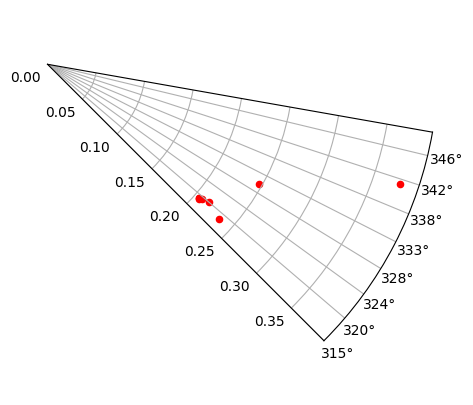

In [40]:
polar = np.array([ [math.hypot(p.real,p.imag), np.angle(p)] for p in path])
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, polar=True)
ax.scatter(polar[:,1], polar[:,0],s=20, color='red')
ax.set_thetamin(315)
ax.set_thetamax(350)
plt.show()

In [41]:
def get_NN(neighbours, level, target=[]):
    rotation = rotate_ccw19 if (level%2==1) else 1
    # each neighbours's neighbours will contains original neighbours and the target
    # but it is not correct to exclude those "duplicated" neigbhours to reduce computation.
    # since it's neighbour may be the zero cell itself.
    exclude = target
    tmp_nn = np.repeat(neighbours,7).reshape(len(neighbours), -1)
    scaled_rotated_directions = directions*(scale_down**(level) * rotation)
    result = tmp_nn - scaled_rotated_directions
    idx,jdx = np.where(np.abs(result-exclude)<1e-9)
    result[idx,jdx]= np.inf
    result[:,0]=np.inf
    return result

In [42]:
nn = get_NN(neighbours, 8, [current_pos])
scaled_directions = directions * (scale_down**(len(cell_ids)-1) * rotate_ccw19)
all_zeros = path[-2] + 3  * scaled_directions

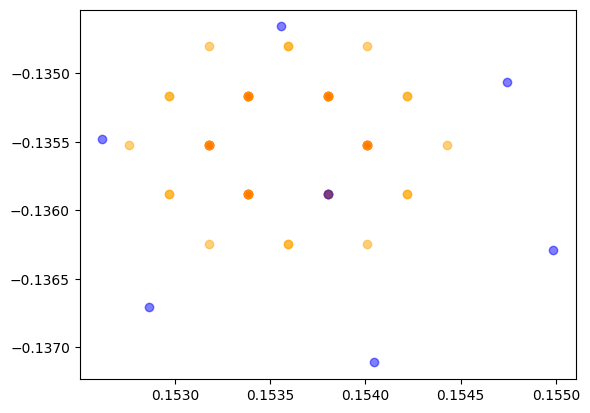

In [47]:
fig, ax = plt.subplots()
X = [x.real for x in neighbours]
Y = [x.imag for x in neighbours]
ax.scatter(X,Y, color='red')
X1 = [i.real for i in nn.flatten() if (i != np.inf)]
Y1 = [i.imag for i in nn.flatten() if (i != np.inf)]
ax.scatter(X1,Y1, color='orange', alpha=0.5)
X2 = [i.real for i in all_zeros]
Y2 = [i.imag for i in all_zeros]
ax.scatter(X2,Y2, color='blue', alpha=0.5)

In [33]:
def find_neighbours(cell_id):
    if (cell_id[-1] == '0'):
        return np.array([cell_id[: -1] + f'{i}' for i in range(1, 7)])
    # omit the prefix face id at current stage.
    facesid = cell_id[:2]
    cell_id = cell_id[2:]
    path = _genpath(cell_id)
    # initialize at target cell level
    current_pos = path[-1]
    rotation = rotate_ccw19 if ((len(cell_id) - 1) % 2 == 1) else 1
    neighbours = current_pos + directions[1:] * (scale_down**(len(cell_id) - 1) * rotation)
    new_path = [0] + path
    neighbours_cellid = []
    # we iterate from the back, start from -2
    for p in new_path[-2::-1]:
        # we are working at level = p + 1
        level = path.index(p) + 1 if (p != 0) else 0
        p = new_path[0] if (p == 0) else p
        # get the ratation of p level
        rotation = rotate_ccw19 if ((level - 1) % 2 == 1 and (p != 0)) else 1
        # get the neighbour's neighbours at working level
        # print(f'{p} {level} {rotation} {(np.power(scale_down,level))}')
        nn = _get_neighbours(neighbours, level, [current_pos])
        # get all near by zero cells location at working level, we have to rotate it by rotation at p level
        # here we use the property that zero cells are 3 unit away from each other at 6 direction (center at any zero cell)
        scaled_directions = directions * (np.power(scale_down, level) * rotation)
        # we center at the p
        nearby_zeros = (p + 3 * scaled_directions).reshape(len(directions), 1, 1)
        # expand the dim to perform pair-wise distance between neighbour's neighbours and nearby zeros (7 direction, including center)
        distance_matrix = np.abs(np.repeat(nn[np.newaxis, :, :], len(directions), axis=0) - nearby_zeros) / (np.power(scale_down, level))

In [34]:
find_neighbours('00050005452')

NameError: name '_genpath' is not defined

In [ ]:
fig, ax = plt.subplots()
X = [x.real for x in neighbours]
Y = [x.imag for x in neighbours]
ax.scatter(X,Y, color='red')
X1 = [i.real for i in nn.flatten() if (i != np.inf)]
Y1 = [i.imag for i in nn.flatten() if (i != np.inf)]
ax.scatter(X1,Y1, color='orange', alpha=0.5)
X2 = [i.real for i in nearby_zeros]
Y2 = [i.imag for i in nearby_zeros]
ax.scatter(X2,Y2, color='blue', alpha=0.5)

In [ ]:
parent_child = dggrid.grid_cell_polygons_from_cellids(['0042340315'], 'IGEO7', 9, clip_subset_type='COARSE_CELLS', clip_cell_res=8, input_address_type='Z7_STRING', output_address_type='Z7_STRING')

In [ ]:
parent_child.reset_index().plot(column='index',cmap='tab20')

In [ ]:
ax = parent_child.plot()
parent_child.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

In [16]:
np.angle(directions[3],deg=True)

0.0